In [47]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import mode
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.optimize import curve_fit
from scipy import median
import math

import pandas_gbq
import pydata_google_auth
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g
import gspread
from googleapiclient.discovery import build

from datetime import datetime, timedelta, date

import os.path
import logging

import nest_asyncio
nest_asyncio.apply()

from tqdm.notebook import tqdm
import time

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# севис где необходимо авторизироваться (для доступа к BQ)
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform'
]

# создание учетных данных для аворизации
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

# создание логгера для подключения к BQ через pandas_gbq
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())


def execute(sql):
    
    '''
    Функция запроса к BQ с помощью pandas_gbq
    
    Параметры:
    __________
    sql : str
        запрос на SQL в виде строки
    '''
    
    res = pandas_gbq.read_gbq(
        sql,
        project_id='playgendary-bi',
        credentials=credentials,
    )
    return res

### Соотношение fail_rate / attempts

In [5]:
# прохождение уровней игроками
sql_difficulty = f'''
WITH start_finish AS(
    SELECT DISTINCT
        user_id,
        ab_test,
        lvl_nm,
        project_version,
        attempt_id,
        event_name,
        event_date,
        event_timestamp,
        platform,
        --через LEAD так как есть событие старта и финиша уровня
        LEAD(ifnull(turns_purchased,0)) 
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) turns,
        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b1') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b1') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b1,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b2') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b2') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b2,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b3') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b3') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b3,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b7') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b7') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b7,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b8') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b8') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b8,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b9') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b9') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b9,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b4') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b4,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b5') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b5,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b6') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b6,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b10') AS int64),
            0))  OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b10,
        
        LEAD(IF(ifnull(winstreak,0)=0, 0, 1)) 
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) ws_b,
            
        LEAD(IF(ifnull(lvl_result,0)=1, 1, 0))
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) complete
    FROM
    `marketing-analytics-235713.aggregated_events_hd.user_level_lvl_start_finish`
    WHERE event_date >= '2021-04-15'
    -- игрок не должен быть в тесте новой динамики
    AND ab_test <> 'NewLevelDynamic200/AbGroup'
    ORDER BY user_id, event_timestamp
), 
clear_start_finish AS(
        SELECT
        sf.user_id,
        sf.lvl_nm,
        sf.project_version version,
        sf.attempt_id,
        sf.event_date,
        ifnull((sf.turns + sf.b1 + sf.b2 + sf.b3 + sf.b4 + sf.b5
        + sf.b6 + sf.b7 + sf.b8 + sf.b9 + sf.b10 + sf.ws_b), 0) bonus,
        ifnull(sf.complete, 0) complete
    FROM start_finish sf
    INNER JOIN `marketing-analytics-235713.aggregated_events_hd.lvls_version` lv
    ON sf.lvl_nm = lv.lvl_number
    AND sf.event_date >= lv.min_date
    AND sf.project_version >= lv.project_version
    WHERE sf.event_name = 'level_start'

)
SELECT
    user_id,
    lvl_nm lvl_number,
    version,
    SUM(IF(complete=0, 1, 0)) fails,
    SUM(IF(complete=1, 1, 0)) completes,
    SUM(IF(complete=0 AND bonus=0, 1, 0)) fails_wo_b,
    SUM(IF(complete=1 AND bonus=0, 1, 0)) completes_wo_b
FROM clear_start_finish
GROUP BY user_id, lvl_number, version
HAVING completes=1
'''

df_difficulty = execute(sql_difficulty)
df_difficulty.sample(3)

Requesting query... 
Query running...
Job ID: 067c7bfc-e7a7-47ec-92d0-0e2adf3ef95a
Query done.
Cache hit.



Downloading:  88%|█████████████████████████████████████████████      | 24805509/28103015 [2:41:51<21:30, 2554.29rows/s]


Downloading:   1%|▎                                                     | 153003/28103015 [00:10<31:07, 14968.52rows/s]

Downloading:   1%|▌                                                     | 305781/28103015 [00:20<31:12, 14844.60rows/s]

Downloading:   2%|▉                                                     | 458996/28103015 [00:30<31:00, 14857.75rows/s]

Downloading:   2%|█▏                                                    | 612152/28103015 [00:41<31:06, 14731.76rows/s]

Downloading:   3%|█▍                                                    | 765315/28103015 [00:52<31:13, 14592.44rows/s]

Downloading:   3%|█▊                                                    | 918479/28103015 [01:02<30:52, 14672.83rows/s]

Downloading:   4%|██                       

Downloading:  65%|█████████████████████████████████▋                  | 18221198/28103015 [21:02<10:57, 15018.56rows/s]

Downloading:  65%|█████████████████████████████████▉                  | 18374356/28103015 [21:12<10:43, 15120.67rows/s]

Downloading:  66%|██████████████████████████████████▎                 | 18527512/28103015 [21:24<10:55, 14615.57rows/s]

Downloading:  66%|██████████████████████████████████▌                 | 18680638/28103015 [21:34<10:46, 14576.38rows/s]

Downloading:  67%|██████████████████████████████████▊                 | 18833786/28103015 [21:45<10:49, 14271.02rows/s]

Downloading:  68%|███████████████████████████████████▏                | 18986919/28103015 [21:56<10:30, 14469.39rows/s]

Downloading:  68%|███████████████████████████████████▍                | 19140054/28103015 [22:07<10:24, 14362.51rows/s]

Downloading:  69%|███████████████████████████████████▋                | 19293189/28103015 [22:17<10:19, 14230.64rows/s]

Downloading:  69%|██████████████

,user_id,lvl_number,version,fails,completes,fails_wo_b,completes_wo_b
27639098,a34d1ef4206fa0f78c7d986399f5a6dc,3,1.6.4226,0,1,0,1
5240934,50f6878778c6e422a651e76d54776e39,562,1.6.4226,4,1,0,0
25655725,6B54AD4C927045C5870558DBFBC037AD,3,1.6.4156,0,1,0,1


In [6]:
# вычисление общего количества попыток с бустами и без
df_difficulty['attempts'] = df_difficulty['fails'] + df_difficulty['completes']
df_difficulty['attempts_wo_b'] = df_difficulty['fails_wo_b'] + df_difficulty['completes_wo_b']

In [7]:
# расчет сложности по уровням
df_result = (df_difficulty.groupby('lvl_number')['fails'].sum() /\
    (df_difficulty.groupby('lvl_number')['attempts'].sum())) \
    .to_frame().reset_index().rename(columns={0:'faile_rate'})
df_result.head()

,lvl_number,faile_rate
0,1,0.016791
1,2,0.013463
2,3,0.019458
3,4,0.018526
4,5,0.021142


In [8]:
# количество попыток
df_num_attempts_wo_b = df_difficulty.groupby('lvl_number')[['attempts']] \
                                                .sum() \
                                                .reset_index()
df_num_attempts_wo_b.head()

,lvl_number,attempts
0,1,588645
1,2,530105
2,3,486223
3,4,454826
4,5,434534


In [9]:
# среднее количество попыток
df_median_attempts = df_difficulty \
                    .groupby('lvl_number')['attempts'].apply(median) \
                    .to_frame().reset_index() \
                    .rename(columns={'attempts':'attempts_med'})

df_median_attempts.head()

,lvl_number,attempts_med
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [49]:
# среднее количество попыток
df_median_attempts = df_difficulty \
                    .groupby('lvl_number')['attempts'].apply(lambda x: mode(x)[0][0]) \
                    .to_frame().reset_index() \
                    .rename(columns={'attempts':'attempts_med'})

c.head()

,lvl_number,attempts_med
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [10]:
df_stat_attempts = df_num_attempts_wo_b.merge(df_median_attempts)
df_stat_attempts = df_stat_attempts[df_stat_attempts['attempts']>=500]
df_stat_attempts.head()

,lvl_number,attempts,attempts_med
0,1,588645,1.0
1,2,530105,1.0
2,3,486223,1.0
3,4,454826,1.0
4,5,434534,1.0


In [11]:
df_stat_attempts = df_stat_attempts.merge(df_result)
df_stat_attempts.head()

,lvl_number,attempts,attempts_med,faile_rate
0,1,588645,1.0,0.016791
1,2,530105,1.0,0.013463
2,3,486223,1.0,0.019458
3,4,454826,1.0,0.018526
4,5,434534,1.0,0.021142


In [50]:
df_stat_attempts['attempts_med'].value_counts()

1.0     957
2.0     544
3.0     329
4.0     176
5.0     139
6.0      97
7.0      51
8.0      42
9.0      24
10.0     15
11.0      9
13.0      3
4.5       3
14.0      2
15.0      2
12.0      2
3.5       2
17.0      1
1.5       1
Name: attempts_med, dtype: int64

In [1073]:
np.arange(1, 17, 0.25)

array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,
        3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,
        5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,
        7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75,
       10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  ,
       12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25,
       14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
       16.75])

In [13]:
from scipy import interpolate
y = df_stat_attempts["attempts_med"]
x = df_stat_attempts["faile_rate"]
func = interpolate.interp1d(x, y)

In [14]:
func

In [43]:
fr = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.82, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96])

In [44]:
att = np.round(func(fr), 2)

In [46]:
pd.DataFrame(np.vstack((fr,att))).T.to_clipboard()

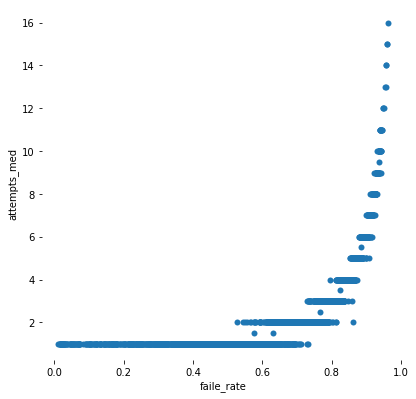

In [1078]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="faile_rate", y="attempts_med", linewidth=0, data=df_stat_attempts, ax=ax)
# sns.scatterplot(x=attempts, y=fail_rate, linewidth=0, ax=ax)
plt.show()

In [1062]:
attempts = np.arange(1, 16, 0.2)
fail_rate = func(0.96)
fail_rate

array(15.11382104)

In [1]:
def fr_attempts(x, a, b, c):
    return a*np.log(x + b) + c

In [2]:
attempts = np.array([x for x in range(1, 21)])
attempts

NameError: name 'np' is not defined

In [1020]:
popt, _ = curve_fit(fr_attempts, df_stat_attempts['attempts_med'], df_stat_attempts['faile_rate'])
fail_rate = fr_attempts(attempts, popt[0], popt[1], popt[2])
fail_rate

C:\Users\aleksandr.stepa\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([0.41833541, 0.70493567, 0.78395909, 0.83165084, 0.86591563,
       0.89267611, 0.91463593, 0.9332583 , 0.94942511, 0.96370915,
       0.97650355, 0.98808989, 0.99867674, 1.00842293, 1.01745221,
       1.02586285, 1.03373422, 1.04113133, 1.04810809, 1.05470971])

- Выгрузить данные по сложности уровней без бустов для старого апдейта и для нового.
- Сравнить уровни в которых не было правок за периоды выгрузки и где статистика релевантна между собой. Сложность должна быть прежней по апдейтам
- Эту процедуру провести для всех механик. Желательно по 2-3 уровня для каждой механики глянуть. Сведения об уровнях и механиках на них  документе: https://docs.google.com/spreadsheets/d/1YlLxNcT3RMHuxBDNjtLzvq8iI0YFwncbnYMWD-1ku_c/edit?usp=drive_web&ouid=100190984773960841634 Если мы видим проблему - отмечаем ее и выясняем с помощью QA в чем дело тк возможно баг или поломка механики.
- Смотрим общую кривую сложности  на предмет адекватности и соответствия плану. Самые критичные проблемы правим.

## Парсим док с уровнями, которые не менялись на новой версии

Док с уровнями
https://docs.google.com/spreadsheets/d/1obojMTS9FGJjHIpa6YXbCK7NQrCpHNiIlWUmWg66KsY/edit#gid=710853096

In [1083]:
# для дступа к Spreadsheets
SCOPES_SPREADSHEETS = ['https://spreadsheets.google.com/feeds',
                       'https://www.googleapis.com/auth/drive'
                      ]

# ключ сервисного аккаунта для доступа к Spreadsheets (лежит в одной директории с блокнотом)
google_key_file = 'marketing-analytics-235713.json'

# создание учетных данных для доступа к Spreadsheets
credentials_sh = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, SCOPES_SPREADSHEETS)

# создание подключения к Spreadsheets
gc = gspread.authorize(credentials_sh)

# из адресной строки странички Spreadsheets
SPREADSHEET_ID = '1obojMTS9FGJjHIpa6YXbCK7NQrCpHNiIlWUmWg66KsY'

# открытие книги
workbook = gc.open_by_key(SPREADSHEET_ID)
# выбор страницы
sheet = workbook.worksheet('Изменения по датам')
# извлечение данных
values = sheet.get_all_values()

# запись в фрейм
df = pd.DataFrame(values[2:], columns=values[0])
df['lvl_number'] = df['lvl_number'].astype(int)

# получение уровней без изменений на необходимую дату
# надо выбрать уровни которые не менялись 14 дней до и после релиза
no_change_lvls = tuple(df[(df['22.06.2021']=='')&(df['28.06.2021']=='')]['lvl_number'].unique())

## Получение всех возможных механик/целей

In [1084]:
#t0, t1, t2, t3, t4, t5, t6 - одинаковые механики собрать плитки определенных цветов
sql_lvl_targets = '''
SELECT DISTINCT
    IF(lvl_target_id in ('t0', 't1', 't2', 't3', 't4', 't5', 't6'), 't0', lvl_target_id) lvl_target 
FROM
    marketing-analytics-235713.aggregated_events_hd.lvl_targets
'''
df_lvl_targets = execute(sql_lvl_targets)
df_lvl_targets['lvl_target'].unique()

Requesting query... 
Requesting query... 
Query running...
Query running...
Job ID: 54d97642-17de-416a-96f1-fe49515fd84b
Job ID: 54d97642-17de-416a-96f1-fe49515fd84b
Query done.
Processed: 151.0 B Billed: 10.0 MB
Query done.
Processed: 151.0 B Billed: 10.0 MB
Standard price: $0.00 USD

Standard price: $0.00 USD

Downloading: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 147.13rows/s]
Got 24 rows.

Got 24 rows.



array(['t0', 't16', 't17', 't18', 't22', 't23', 't25', 't26', 't27',
       't28', 't29', 't41', 't42', 't43', 't44', 't45', 't46', 't200',
       't310', 't400', 't500', 't700', 't900', 't1000'], dtype=object)

## Получим список уровней с таргетами

In [1155]:
# регулярки для парсинга целей
reg_target_1 = '\\{\\"(t\\d+)\\":\\d.?\\d*[,\\}]'
reg_target_2 = '\\{.*,\\"(t\\d+)\\":\\d.?\\d*\\}'

#min необходимое кол-во уникальных игроков ну уровне
MIN_USERS = 100 

# IOS или ANDROID
PLATFORM = 'ANDROID'

#сначала указывается новая, потом старая версия
VERSIONS = ('1.6.4226', '1.6.3875')

# дата начала раскатки новой версии
date_x = date(2021, 6, 25)

# период проверки в 14 дней обе стороны от начала раскатки версии
date1 = (date_x - timedelta(14)).strftime('%Y-%m-%d')
date2 = (date_x + timedelta(14)).strftime('%Y-%m-%d')
print(date1, date2)

2021-06-11 2021-07-09


## Версия через project_version и таблицу с попытками

In [1156]:
# ихвлечение целей уровней
sql_target = f'''
WITH target_name AS (
    (SELECT
        lvl_nm,
        regexp_extract(lvl_target, r"{reg_target_1}") target_id,
        project_version,
        count(distinct user_id) cnt_users
    FROM
        `marketing-analytics-235713.aggregated_events_hd.user_level_lvl_start_finish`
    WHERE 
        event_date between '{date1}' AND '{date2}'
        AND install_source in ('com.android.vending', 'iTunes')
        AND event_name = 'level_finish'
        AND lvl_nm > 0 
        AND project_version in {VERSIONS}
    GROUP BY
        1, 2, 3
    HAVING 
        cnt_users >= {MIN_USERS}/2
    ORDER BY
        lvl_nm
        )
        
    UNION ALL
    
    (SELECT
        lvl_nm,
        regexp_extract(lvl_target, r"{reg_target_2}") target_id,
        project_version,
        count(distinct user_id) cnt_users
    FROM
        `marketing-analytics-235713.aggregated_events_hd.user_level_lvl_start_finish`
    WHERE 
        event_date between '{date1}' AND '{date2}'
        AND install_source in ('com.android.vending', 'iTunes')
        AND event_name = 'level_finish'
        AND lvl_nm > 0 
        AND project_version in {VERSIONS}
    GROUP BY
        1, 2, 3
    HAVING 
        cnt_users >= {MIN_USERS}/2
    ORDER BY
        lvl_nm
        )    
)
SELECT DISTINCT
    lvl_nm,
    IF(target_id in ('t0', 't1', 't2', 't3', 't4', 't5', 't6'), 't0', target_id) target_id
FROM target_name
WHERE target_id is not NULL
ORDER BY lvl_nm
'''
df_target = execute(sql_target)
df_target

Requesting query... 
Requesting query... 
Query running...
Query running...
Job ID: b70c9336-b49f-4ebc-9257-0229024e370b
Job ID: b70c9336-b49f-4ebc-9257-0229024e370b
Query done.
Processed: 7.8 GB Billed: 7.8 GB
Query done.
Processed: 7.8 GB Billed: 7.8 GB
Standard price: $0.04 USD

Standard price: $0.04 USD

Downloading: 100%|████████████████████████████████████████████████████████████| 3649/3649 [00:00<00:00, 18397.35rows/s]
Got 3649 rows.

Got 3649 rows.



,lvl_nm,target_id
0,1,t0
1,2,t0
2,3,t0
3,4,t0
4,5,t23
...,...,...
3644,2247,t310
3645,2248,t900
3646,2248,t42
3647,2249,t41


## Берем 3 механики для каждого таргета

In [1157]:
# отбор уровней, которые не менялись
df_target = df_target[df_target['lvl_nm'].isin(no_change_lvls)]
df_target.groupby('target_id').lvl_nm.count().sort_values()

target_id
t0        22
t18       70
t900      71
t41       78
t17       89
t400      99
t27      114
t29      146
t1000    153
t43      154
t45      161
t28      225
t42      231
t22      234
t500     238
t46      240
t25      241
t16      257
t23      305
t310     312
Name: lvl_nm, dtype: int64

In [1158]:
# кортеж, по три уровня из каждой механики/цели
lvls = () 
for target in df_target['target_id'].unique():
    lvls += tuple(df_target.loc[df_target['target_id'] == target, 'lvl_nm'].sample(8).values)
print(lvls)

(1248, 581, 605, 81, 3, 2, 452, 669, 720, 1295, 1414, 226, 1653, 1132, 1095, 1605, 1808, 315, 344, 675, 333, 1593, 1966, 1031, 1529, 1986, 563, 231, 19, 917, 892, 109, 558, 1561, 1833, 1464, 330, 2042, 549, 495, 123, 113, 796, 1449, 466, 402, 479, 733, 634, 1245, 496, 1218, 936, 907, 36, 1284, 613, 2063, 1368, 77, 1461, 321, 1622, 1382, 1841, 1297, 1262, 649, 2062, 318, 1453, 733, 670, 1850, 1899, 1598, 164, 240, 509, 1526, 596, 753, 192, 761, 434, 1211, 204, 1110, 1330, 1630, 554, 632, 186, 492, 1871, 665, 739, 1527, 156, 839, 1584, 112, 544, 1485, 446, 344, 772, 1826, 1989, 282, 1889, 1077, 623, 1204, 1259, 1588, 409, 1096, 2027, 1806, 967, 460, 400, 1807, 1468, 1771, 1445, 1922, 1033, 729, 1545, 1801, 1780, 1745, 874, 963, 2032, 521, 1301, 572, 1279, 601, 848, 1593, 1688, 1703, 1289, 627, 1264, 1168, 1252, 1454, 833, 813, 735, 1438, 1913, 769, 786, 2030)


In [1159]:
# # если обязательно нужно включить какие-то уровни
# lvls_add = (25, 347, 444, 552, 70)
# lvls = lvls + lvls_add

## Данные попыткам всех пользователей

In [1160]:
# прохождение уровней игроками
sql_difficulty = f'''
WITH start_finish AS(
    SELECT DISTINCT
        user_id,
        ab_test,
        lvl_nm,
        project_version,
        attempt_id,
        event_name,
        event_date,
        event_timestamp,
        platform,
        --через LEAD так как есть событие старта и финиша уровня
        LEAD(ifnull(turns_purchased,0)) 
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) turns,
        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b1') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b1') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b1,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b2') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b2') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b2,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b3') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b3') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b3,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b7') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b7') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b7,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b8') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b8') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b8,

        ifnull(CAST(json_EXTRACT(boosters_at_start,
                '$.b9') AS int64),
            0) + LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b9') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b9,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b4') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b4,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b5') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b5,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b6') AS int64),
            0)) OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b6,

        LEAD(ifnull(CAST(json_EXTRACT(boosters_used,
                '$.b10') AS int64),
            0))  OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) b10,
        
        LEAD(IF(ifnull(winstreak,0)=0, 0, 1)) 
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) ws_b,
            
        LEAD(IF(ifnull(lvl_result,0)=1, 1, 0))
            OVER(PARTITION BY user_id, lvl_nm, attempt_id ORDER BY event_timestamp) complete
    FROM
    `marketing-analytics-235713.aggregated_events_hd.user_level_lvl_start_finish`
    WHERE event_date BETWEEN '{date1}' AND '{date2}'
    AND platform = '{PLATFORM}'
    AND project_version in {VERSIONS}
    -- игрок не должен быть в тесте новой динамики
    AND ab_test <> 'NewLevelDynamic200/AbGroup'
    ORDER BY user_id, event_timestamp
), 
clear_start_finish AS(
        SELECT
        sf.user_id,
        sf.lvl_nm,
        sf.project_version version,
        sf.attempt_id,
        sf.event_date,
        ifnull((sf.turns + sf.b1 + sf.b2 + sf.b3 + sf.b4 + sf.b5
        + sf.b6 + sf.b7 + sf.b8 + sf.b9 + sf.b10 + sf.ws_b), 0) bonus,
        ifnull(sf.complete, 0) complete
    FROM start_finish sf
--    INNER JOIN `marketing-analytics-235713.aggregated_events_hd.lvls_version` lv
--    ON sf.lvl_nm = lv.lvl_number
--    AND sf.event_date >= lv.min_date
--    AND sf.project_version >= lv.project_version
    WHERE sf.event_name = 'level_start'
--    AND sf.complete IS NOT NULL
)
SELECT
    user_id,
    lvl_nm lvl_number,
    version,
    SUM(IF(complete=0, 1, 0)) fails,
    SUM(IF(complete=1, 1, 0)) completes,
    SUM(IF(complete=0 AND bonus=0, 1, 0)) fails_wo_b,
    SUM(IF(complete=1 AND bonus=0, 1, 0)) completes_wo_b
FROM clear_start_finish
GROUP BY user_id, lvl_number, version
HAVING lvl_number IN {no_change_lvls}
'''

df_difficulty = execute(sql_difficulty)
df_difficulty.sample(3)

Requesting query... 
Requesting query... 
Query running...
Query running...
Job ID: c556e0c4-be43-4f97-b263-e0ef3c9fd10a
Job ID: c556e0c4-be43-4f97-b263-e0ef3c9fd10a
  Elapsed 6.09 s. Waiting...
  Elapsed 6.09 s. Waiting...
  Elapsed 7.29 s. Waiting...
  Elapsed 7.29 s. Waiting...
  Elapsed 8.4 s. Waiting...
  Elapsed 8.4 s. Waiting...
  Elapsed 9.54 s. Waiting...
  Elapsed 9.54 s. Waiting...
  Elapsed 10.67 s. Waiting...
  Elapsed 10.67 s. Waiting...
  Elapsed 11.8 s. Waiting...
  Elapsed 11.8 s. Waiting...
  Elapsed 12.94 s. Waiting...
  Elapsed 12.94 s. Waiting...
  Elapsed 14.09 s. Waiting...
  Elapsed 14.09 s. Waiting...
  Elapsed 15.21 s. Waiting...
  Elapsed 15.21 s. Waiting...
  Elapsed 16.34 s. Waiting...
  Elapsed 16.34 s. Waiting...
  Elapsed 17.47 s. Waiting...
  Elapsed 17.47 s. Waiting...
  Elapsed 18.59 s. Waiting...
  Elapsed 18.59 s. Waiting...
  Elapsed 19.7 s. Waiting...
  Elapsed 19.7 s. Waiting...
Query done.
Processed: 14.2 GB Billed: 14.2 GB
Query done.
Processed

,user_id,lvl_number,version,fails,completes,fails_wo_b,completes_wo_b
2183460,a7d962cf7893641c769b8ba7f717592c,2,1.6.4226,0,1,0,1
3408928,a72bd20e9395550a6de1e54f1529a258,35,1.6.3875,0,1,0,0
2030230,460cf6825b172dd555419a3a9dd471d9,4,1.6.3875,0,1,0,1


In [1120]:
# проверка, не попал ли измененный уровень (смотрим в таблице)
df_difficulty[df_difficulty['lvl_number']==444]

,user_id,lvl_number,version,fails,completes,fails_wo_b,completes_wo_b


In [1162]:
# фильтрация случаев нескольких успешных проходений одного уровня
df_difficulty = df_difficulty[df_difficulty['completes']<=1].copy()

In [1163]:
# вычисление общего количества попыток с бустами и без
df_difficulty['attempts'] = df_difficulty['fails'] + df_difficulty['completes']
df_difficulty['attempts_wo_b'] = df_difficulty['fails_wo_b'] + df_difficulty['completes_wo_b']

In [1164]:
# памятник тому, почему надо избегать циклов
# df_attempt_norm = pd.DataFrame()
# for version in tqdm(df_difficulty['version'].unique()):
#     for level in tqdm(df_difficulty['lvl_number'].unique()):    
#         df_level = df_difficulty.loc[(df_difficulty['lvl_number']==level)
#                                   &(df_difficulty['version']==version)].copy()
#         high = np.quantile(df_level['attempts'], 0.95)
#         df_level = df_level[df_level['attempts']<=high]
#         df_attempt_norm = pd.concat([df_attempt_norm, df_level])

In [1165]:
# # 95% перцентиль по количеству попыток на уровне
# df_95_perc = df_difficulty.groupby(['version', 'lvl_number'])['attempts'] \
#                                 .apply(np.array) \
#                                 .apply(lambda x: np.quantile(x, 0.90)) \
#                                 .to_frame().reset_index() \
#                                 .rename(columns={'attempts':'95_perc'})

# df_difficulty = df_difficulty.merge(df_95_perc, on=['version', 'lvl_number'], how='left')
# df_difficulty.head()

In [1166]:
# df_difficulty.drop('95_perc', axis=1, inplace=True)
# df_difficulty.head()

In [1167]:
# # оставляем только игроков с количеством попыток меньше 90% перцентиля
# df_difficulty = df_difficulty[df_difficulty['attempts']<=df_difficulty['95_perc']].copy()

In [1168]:
# наблюдаемая частота событий fails/attempts
df_observed = df_difficulty.groupby(['version', 'lvl_number'])[['fails', 'completes']] \
                                        .sum() \
                                        .reset_index() \
                                        .sort_values(by='lvl_number', ignore_index=True)

df_observed = df_observed[df_observed['fails']!=0].copy()
df_observed.head()

,version,lvl_number,fails,completes
0,1.6.3875,1,1567,18444
1,1.6.4226,1,5955,67190
2,1.6.4226,2,3109,60150
3,1.6.3875,2,1088,16743
4,1.6.3875,3,1076,15321


In [1169]:
# подготовка данных для проведения кси2 теста Пирсона
df_observed['f_c'] = df_observed.apply(lambda x: [x['fails'], x['completes']], axis=1)
df_observed = df_observed.groupby('lvl_number')['f_c'].apply(list).to_frame().reset_index()
df_observed.head()

,lvl_number,f_c
0,1,"[[1567, 18444], [5955, 67190]]"
1,2,"[[3109, 60150], [1088, 16743]]"
2,3,"[[1076, 15321], [3106, 54526]]"
3,4,"[[843, 14440], [2151, 50745]]"
4,5,"[[753, 13748], [1883, 48199]]"


In [1170]:
# проведение теста и получение pvalue
df_observed['chi_pvalue'] = df_observed.apply(lambda x: chi2_contingency(np.array(x['f_c']))[1], axis=1)

In [1171]:
# # расчеты для определения детектируемой разницы 
# df_lvl_mean = df_difficulty[df_difficulty['version']==VERSIONS[1]] \
#                                 .groupby('lvl_number')[['attempts']].mean() \
#                                 .rename(columns={'attempts':'mean'})
# df_lvl_std = df_difficulty[df_difficulty['version']==VERSIONS[1]] \
#                                 .groupby('lvl_number')[['attempts']].std() \
#                                 .rename(columns={'attempts':'std'})
# df_lvl_n = df_difficulty[df_difficulty['version']==VERSIONS[0]] \
#                                 .groupby('lvl_number')[['user_id']] \
#                                 .nunique().rename(columns={'user_id':'n'})

In [1172]:
# # детектируемая разница
# df_sig = ((((norm.ppf(1-0.05/2) + norm.ppf(0.8))) * df_lvl_std['std']) /\
# (df_lvl_n['n'] * (1*1) / (1+1)).apply(math.sqrt) / df_lvl_mean['mean']).to_frame().reset_index().rename(columns={0:'sig ∆'})

In [1173]:
# # проведенеия Т теста между уровнями
# df_ttest = df_difficulty.groupby(['lvl_number', 'version'])['attempts'].apply(np.array) \
#                                                     .to_frame().reset_index() \
#                                                     .groupby('lvl_number')['attempts'] \
#                                                     .apply(np.array) \
#                                                     .to_frame().reset_index()

# df_ttest['pvalue'] = df_ttest['attempts'].apply(lambda x: ttest_ind(x[0], x[1], equal_var=False)[1])
# df_ttest.head()

In [1174]:
# расчет сложности по уровням с бустами
df_result = (df_difficulty.groupby(['version', 'lvl_number'])['fails'].sum() /\
    (df_difficulty.groupby(['version', 'lvl_number'])['attempts'].sum()))

In [1175]:
# сложность по уровням с бустами
l2 = df_result.reset_index().pivot_table(index='lvl_number',
                                         columns='version',
                                         values=0).reset_index()#.to_clipboard()

In [1176]:
# расчет сложности по уровням без бустов
df_result_wob = (df_difficulty.groupby(['version', 'lvl_number'])['fails_wo_b'].sum() /\
    (df_difficulty.groupby(['version', 'lvl_number'])['attempts_wo_b'].sum()))

In [1177]:
# сложность по уровням без бустов
l3 = df_result_wob.reset_index().pivot_table(index='lvl_number',
                                             columns='version',
                                             values=0).reset_index()#.to_clipboard()

In [1178]:
# мерж сложности с бустами и без
itog = pd.merge(l2, l3, how='left', on='lvl_number')
itog.columns.name = None

## Попытки

In [1179]:
# необходимый порядок столбцов
column_order = ['attempts', 'fails', 'completes', 'attempts_wo_b', 'fails_wo_b', 'completes_wo_b']

# суммирование всех попыток по уровням-версиям
res_df = df_difficulty.groupby(['version', 'lvl_number'], as_index=False)[column_order].sum()\
        .pivot_table(index='lvl_number',
                     columns='version',
                     values=column_order)

# res_df = res_df.reindex(column_order, axis=1, level=0)
# убираем второй уровень столбцов
res_df.columns = [(level[0] + ' ' + level[1]) if level[1] else level[0] for level in res_df.columns]
res_df.head()

,attempts 1.6.3875,attempts 1.6.4226,attempts_wo_b 1.6.3875,attempts_wo_b 1.6.4226,completes 1.6.3875,completes 1.6.4226,completes_wo_b 1.6.3875,completes_wo_b 1.6.4226,fails 1.6.3875,fails 1.6.4226,fails_wo_b 1.6.3875,fails_wo_b 1.6.4226
lvl_number,,,,,,,,,,,,
1,20011,73145,20011,73145,18444,67190,18444,67190,1567,5955,1567,5955
2,17831,63259,17787,63191,16743,60150,16700,60082,1088,3109,1087,3109
3,16397,57632,16352,57577,15321,54526,15279,54471,1076,3106,1073,3106
4,15283,52896,15248,52847,14440,50745,14408,50696,843,2151,840,2151
5,14501,50082,14464,50040,13748,48199,13711,48157,753,1883,753,1883


In [1180]:
# мерж сложности и статистики по попыткам
new = pd.merge(itog, res_df.reset_index(), how='left', on='lvl_number')
new.head()

,lvl_number,1.6.3875_x,1.6.4226_x,1.6.3875_y,1.6.4226_y,attempts 1.6.3875,attempts 1.6.4226,attempts_wo_b 1.6.3875,attempts_wo_b 1.6.4226,completes 1.6.3875,completes 1.6.4226,completes_wo_b 1.6.3875,completes_wo_b 1.6.4226,fails 1.6.3875,fails 1.6.4226,fails_wo_b 1.6.3875,fails_wo_b 1.6.4226
0,1,0.078307,0.081414,0.078307,0.081414,20011,73145,20011,73145,18444,67190,18444,67190,1567,5955,1567,5955
1,2,0.061017,0.049147,0.061112,0.049200,17831,63259,17787,63191,16743,60150,16700,60082,1088,3109,1087,3109
2,3,0.065622,0.053894,0.065619,0.053945,16397,57632,16352,57577,15321,54526,15279,54471,1076,3106,1073,3106
3,4,0.055159,0.040665,0.055089,0.040702,15283,52896,15248,52847,14440,50745,14408,50696,843,2151,840,2151
4,5,0.051927,0.037598,0.052060,0.037630,14501,50082,14464,50040,13748,48199,13711,48157,753,1883,753,1883


## Таблица по всем уровням

In [1181]:
# мерж количества уникальных игроков
df_to_gs = pd.merge(new, df_difficulty.groupby(['version', 'lvl_number']).user_id.nunique().reset_index()\
                    .pivot_table(index='lvl_number', columns='version', values='user_id'), on='lvl_number')

In [1182]:
# приводим название столбцов к удобному виду
for col in df_to_gs.columns[1:5]:
    df_to_gs.rename(columns={col:col.replace('_x', ' difficulty')}, inplace=True)
    df_to_gs.rename(columns={col:col.replace('_y', ' difficulty wob')}, inplace=True)

df_to_gs.rename(columns={VERSIONS[0]:'users '+VERSIONS[0]}, inplace=True)
df_to_gs.rename(columns={VERSIONS[1]:'users '+VERSIONS[1]}, inplace=True)                

In [1183]:
# расчет дельты сложности
df_to_gs['difficulty wob ∆%'] = (df_to_gs[f'{VERSIONS[0]} difficulty wob'] -\
                               df_to_gs[f'{VERSIONS[1]} difficulty wob'])/\
                                df_to_gs[f'{VERSIONS[1]} difficulty wob']
df_to_gs['difficulty ∆%'] = (df_to_gs[f'{VERSIONS[0]} difficulty'] -\
                               df_to_gs[f'{VERSIONS[1]} difficulty'])/\
                                df_to_gs[f'{VERSIONS[1]} difficulty']

In [1184]:
# расчет дельты сложности
df_to_gs['difficulty wob ∆'] = (df_to_gs[f'{VERSIONS[0]} difficulty wob'] -\
                               df_to_gs[f'{VERSIONS[1]} difficulty wob'])

df_to_gs['difficulty ∆'] = (df_to_gs[f'{VERSIONS[0]} difficulty'] -\
                               df_to_gs[f'{VERSIONS[1]} difficulty'])

In [1185]:
# прведение к читаемому порядку столбцов
columns = df_to_gs.columns
columns = columns.insert(3, 'difficulty ∆%')
columns = columns.insert(4, 'difficulty ∆')
columns = columns.insert(7, 'difficulty wob ∆%')
columns = columns.insert(8, 'difficulty wob ∆')
columns = columns[:-4]

In [1186]:
df_to_gs = df_to_gs[columns]
df_to_gs = df_to_gs.merge(df_observed[['lvl_number','chi_pvalue']])

In [1187]:
# проверка на пересечение доверительных интервалов
def z_test(x1, x2, n1, n2, m_value=0.05, hypothesis_type='two_sided', result='pvalue'):
    hypothesis_types = {'two_sided': 2, 'one_sided': 1}

    p1 = x1 / n1
    p2 = x2 / n2
    
    p_mean = (x1 + x2) / (n1 + n2)
    z_value = (p1 - p2) / np.sqrt(p_mean * (1 - p_mean) * ((1 / n1) + (1 / n2)))
    
    if result=='pvalue':
        ret = norm.sf(abs(z_value)) * hypothesis_types[hypothesis_type]
    elif result=='ci':
        ret=((np.abs(p1 - p2) - \
           norm.ppf((1-m_value/hypothesis_types[hypothesis_type])) * np.sqrt(p1*(1-p1)/n1) - \
           norm.ppf((1-m_value/hypothesis_types[hypothesis_type])) * np.sqrt(p2*(1-p2)/n2)) < 0)
    else:
        ret='unknow argument'
           
    return ret

In [1188]:
df_to_gs['z_pvalue'] = df_to_gs.apply(lambda x: z_test(x[f'fails {VERSIONS[1]}']
                                                       ,x[f'fails {VERSIONS[0]}']
                                                       ,x[f'attempts {VERSIONS[1]}']
                                                       ,x[f'attempts {VERSIONS[0]}'], result='pvalue'), axis=1)

In [1189]:
df_to_gs['ci_intersection'] = df_to_gs.apply(lambda x: z_test(x[f'fails {VERSIONS[1]}']
                                                       ,x[f'fails {VERSIONS[0]}']
                                                       ,x[f'attempts {VERSIONS[1]}']
                                                       ,x[f'attempts {VERSIONS[0]}'], result='ci'), axis=1)

In [1190]:
# сортировка по разнице сложности и количеству игркоов на уровне
df_to_gs[(df_to_gs[f'users {VERSIONS[1]}']>=100)
                            &(df_to_gs[f'users {VERSIONS[0]}']>=100)] \
                            .sort_values(by='difficulty ∆', key=abs, ascending=False).head()

,lvl_number,1.6.3875 difficulty,1.6.4226 difficulty,difficulty ∆%,difficulty ∆,1.6.3875 difficulty wob,1.6.4226 difficulty wob,difficulty wob ∆%,difficulty wob ∆,attempts 1.6.3875,...,completes_wo_b 1.6.4226,fails 1.6.3875,fails 1.6.4226,fails_wo_b 1.6.3875,fails_wo_b 1.6.4226,users 1.6.3875,users 1.6.4226,chi_pvalue,z_pvalue,ci_intersection
983,1009,0.431655,0.609943,0.413034,0.178288,0.600000,0.887500,0.479167,0.287500,278,...,9,120,638,12,71,160,412,1.344568e-07,9.250516e-08,False
674,684,0.506151,0.637638,0.259777,0.131486,0.695652,0.850000,0.221875,0.154348,569,...,15,288,1274,32,85,282,733,1.903433e-08,1.434370e-08,False
653,663,0.557471,0.671749,0.204994,0.114278,0.758065,0.868421,0.145577,0.110357,696,...,15,388,1586,47,99,312,781,3.918875e-08,3.032354e-08,False
809,819,0.537988,0.649584,0.207432,0.111596,0.666667,0.882353,0.323529,0.215686,487,...,6,262,1014,14,45,226,551,1.170573e-05,9.141272e-06,False
595,605,0.392070,0.500629,0.276885,0.108558,0.571429,0.731183,0.279570,0.159754,681,...,25,267,1194,20,68,415,1193,7.078106e-07,5.653168e-07,False


In [1191]:
# Sheet name
wks_name = f'{PLATFORM}_difficulty'

# Загрузка DataFrame в GoogleSheets
d2g.upload(df_to_gs[(df_to_gs[f'users {VERSIONS[1]}']>=100)
                            &(df_to_gs[f'users {VERSIONS[0]}']>=100)] \
                           .sort_values(by='difficulty ∆', key=abs, ascending=False),
           '1JQ65CtHaQDJ8cw0gqOj0QnzhBGl1RUdEZ6avErZBnB0',
           wks_name,
           credentials=credentials_sh,
           row_names=False
          )

<Worksheet 'ANDROID_difficulty' id:0>

## Уровни по таргетам

In [1192]:
# мерж выбранных по механикам уровней
target_to_gs = pd.merge(df_to_gs[df_to_gs['lvl_number'].isin(lvls)],
                        df_target, left_on='lvl_number', right_on='lvl_nm')
# исключаем уровни с маленьким количеством попыток
target_to_gs = target_to_gs[(target_to_gs[f'attempts_wo_b {VERSIONS[1]}']>=100)&
                           (target_to_gs[f'attempts_wo_b {VERSIONS[0]}']>=100)].copy()

In [1193]:
# Sheet name
wks_name = f'{PLATFORM}_target'

# Загрузка DataFrame в GoogleSheets
d2g.upload(target_to_gs[['lvl_nm', 'target_id', f'{VERSIONS[1]} difficulty wob', f'{VERSIONS[0]} difficulty wob',
              'difficulty wob ∆', f'users {VERSIONS[1]}',  f'users {VERSIONS[0]}']],
           '1JQ65CtHaQDJ8cw0gqOj0QnzhBGl1RUdEZ6avErZBnB0',
           wks_name,
           credentials=credentials_sh,
           row_names=False
          )

<Worksheet 'ANDROID_target' id:1885454744>

In [1194]:
# выбор необходимых колонок
target_to_gs[['lvl_nm', 'target_id', f'{VERSIONS[1]} difficulty wob', f'{VERSIONS[0]} difficulty wob',
              'difficulty wob ∆', f'users {VERSIONS[1]}',  f'users {VERSIONS[0]}']].to_clipboard(index=False)

### Доверительные интервалы

In [1]:
a = 7
[x for x in range(1,a,round(a/4))]

[1, 3, 5]